# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error as mse
import cuqi
from cuqi.testproblem import Deconvolution2D
from cuqi.distribution import Gaussian, Posterior
from cuqi.implicitprior import RestorationPrior, MoreauYoshidaPrior
from cuqi.experimental.mcmc import MYULANew, ULANew
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import mean_squared_error as mse

/home/remi/Documents/post_doc/code/implicit_prior_paper/my_fork/CUQIpy/cuqi/distribution/_smoothed_laplace.py:6: SyntaxWarning: invalid escape sequence '\e'
  """ Smoothed Laplace distribution.
/home/remi/Documents/post_doc/code/implicit_prior_paper/my_fork/CUQIpy/cuqi/implicitprior/_restorator.py:82: SyntaxWarning: invalid escape sequence '\l'
  """
/home/remi/Documents/post_doc/code/implicit_prior_paper/my_fork/CUQIpy/cuqi/problem/_problem.py:22: SyntaxWarning: invalid escape sequence '\m'
  """ Representation of a Bayesian inverse problem defined by any number of densities (distributions and likelihoods), e.g.


In [2]:
import deepinv as dinv

# Goal

The goal of this notebook is to solve the inverse problem

$$
y = Ax + n \ ,
$$

where $A$ is linear forward operator encoding a blur/convolution operation, $n$ is some additive noise with $n \sim \mathcal{N} (0, \sigma^2 I) $ and $y$ is the blurry observation of $y$.

**Goal:** Retrieve $x$ from $y$.

In the Bayesian framework we aim at sampling from the posterior distribution $\pi (x|y)$.

# Principles behind MYULA
The goal is to solve this inverse problem by sampling from the posterior
distribution given by $\pi(x|y) \propto \pi(x) \pi(y|x)$.

We assume a Gaussian likelihood, ie $- \log \pi(y|x) = \|Ax-y \|_2^2/2 \sigma^2$
and a prior such that $- \log \pi (x) =  g(x)$ with $g$ convex.

To sample from $\pi(x|y)$, we are going to apply a ULA based algorithm,
MYULA (https://arxiv.org/pdf/1612.07471).
We recall that ULA

$$x_{k+1} = x_k + \delta \nabla \log \pi(x_k |y) + \sqrt{2 \delta} z_{k+1} \ ,$$

$$x_{k+1} = x_k + \delta \nabla \log \pi(y | x_k) + \delta \nabla \log \pi(x_k) + \sqrt{2 \delta} z_{k+1}$$

with $(z_k)_{k \in \mathbb{N}^*}$ a sequence of independent and
identically distributed Gaussian random variables
with zero mean and identity covariance.

In the case where $\log \pi(x)$ is not differentiable we can
unfortunately not apply ULA. The idea is to consider a surrogate
posterior density $\pi_{\alpha} (x|y) \propto \pi(y|x) \pi_{\alpha} (x)$
where

$\pi_{\alpha}(x) \propto \exp(- g_{\alpha} (x))$

and $g_{\alpha}$ is the
$\alpha$-Moreau envelope of $g$, ie


$$g_\alpha(x) = \operatorname{inf}_z \| x- z \|_2^2/2 \alpha + g(z) \ .$$

$g_\alpha$ is continuously differentiable with $1/\alpha$-Lipschitz gradient and s.t


$\nabla g_{\alpha} (x) = (x- \operatorname{prox}_g^{\alpha} (x))/\alpha$

 with
$$
\operatorname{prox}_g^{\alpha} (x) = \operatorname{argmin}_z \|x-z \|_2^2/2\alpha + g(z)$$
See https://link.springer.com/chapter/10.1007/978-3-319-48311-5_31 for more details.

MYULA consists in applying ULA to a smoothed target distribution. It reads

\begin{align*}
  x_{k+1} &= x_k + \delta \nabla \log \pi_{\alpha}(x_k |y) + \sqrt{2 \delta} z_{k+1}\\
  &= x_k + \delta \nabla \log \pi(y | x_k) + \delta \nabla \log \pi_{\alpha}(x_k) + \sqrt{2 \delta} z_{k+1}\\
  &= x_k + \delta \nabla \log \pi(y | x_k) - \delta (x_k - \operatorname{prox}_g^{\alpha} (x_k))/{\alpha} + \sqrt{2 \delta} z_{k+1}.
  \end{align*}

where $\alpha$ corresponds to the smoothing strength of $g$.

To illustrate MYULA, we will consider $g(x) = \gamma \  TV(x) = \gamma \|\nabla x \|_{2, 1}$,
where $\gamma$ is the regularization parameter which
controls the regularization strength induced by TV.

# Inverse problem definition with CUQIPy

We consider a deconvolution inverse problem given by

$$
\mathbf{y} = \mathbf{A} \mathbf{x} + n \ ,
$$
with $n\sim\mathcal{N}(0, \texttt{sigma2}\  I)$.

See: class:`~cuqi.testproblem.Deconvolution2D` for more details.

In [3]:
A,y_obs,info=Deconvolution2D().get_components()

In the next cell we aim at normalizing the images.

In [4]:
info.exactSolution=info.exactSolution/np.max(info.exactSolution)
info.exactData=A(info.exactSolution)

We set the noise level to `sigma=5/255`.

In [5]:
sigma=5/255.
sigma2=sigma**2

We generate the observation `y_obs`. In order to get reproducible results we set the seed to `0`.

In [6]:
np.random.seed(0)
y_obs=info.exactData+sigma*np.random.normal(loc=0,scale=1,size=info.exactData.shape)

We show the observation and the exact solution.

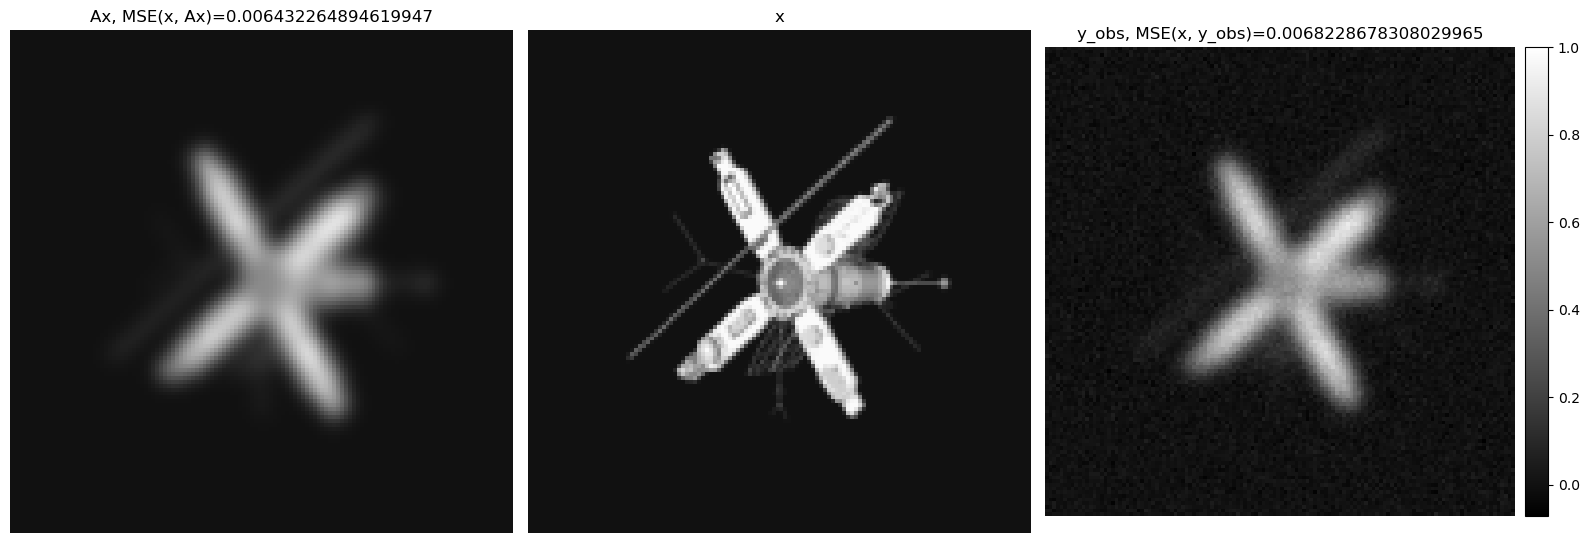

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(16, 16))
# Find the global min and max values to normalize all images equally
vmin = min(info.exactData.min(), info.exactSolution.min(), y_obs.min())
vmax = max(info.exactData.max(), info.exactSolution.max(), y_obs.max())
# Plot each image
im1 = axes[0].imshow(np.reshape(info.exactData, (128, 128)), cmap="gray", vmin=vmin, vmax=vmax)
axes[0].set_title("Ax, MSE(x, Ax)={}".format(mse(info.exactData, info.exactSolution)))
axes[0].axis("off")
im2 = axes[1].imshow(np.reshape(info.exactSolution, (128, 128)), cmap="gray", vmin=vmin, vmax=vmax)
axes[1].set_title("x")
axes[1].axis("off")
im3 = axes[2].imshow(np.reshape(y_obs, (128, 128)), cmap="gray", vmin=vmin, vmax=vmax)
axes[2].set_title("y_obs, MSE(x, y_obs)={}".format(mse(y_obs, info.exactSolution)))
axes[2].axis("off")
# Create an axis for the colorbar and adjust the layout
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.1)
# Add the colorbar
cbar = fig.colorbar(im3, cax=cax)

# Adjust layout to ensure titles and labels fit well
plt.tight_layout()

## Likelihood definition with CUQIPy
We first specify the data distribution as follows:

In [8]:
y=Gaussian(mean=A, cov=sigma2)

Then we can definition the likelihood with:

In [9]:
likelihood=y(y=y_obs)

# RestorationPrior and MoreauYoshidaPrior in CUQIPy
To apply MYULA, we need to define the Moreau-Yoshida prior $\pi_{\alpha}(x)$.

Evaluating this surrogate prior is doable but too intensive from
a computational point of view as it requires to solve an optimization problem.

However to apply MYULA, we only require access to
$\operatorname{prox}_{\gamma \ TV}^{\alpha}$.

$\operatorname{prox}_{\gamma \ TV}^{\alpha}$
is a denoising operator, which takes a signal as input and returns a less noisy
signal.

In CUQIPy, we talk about restoration operators. It is an operator at the
core of a specific type of priors called RestorationPrior. We cannot sample from
these priors but they allow us to define other types of priors.


# RestorationPrior definition in CUQIPy
A restoration operator is associated with a parameter called
$\texttt{restoration}\_{\texttt{strength}}$. This parameter indicates how strong is
the restoration.

For example, when this restoration is a denoiser, an operator
taking an signal as input and returning a less noisy signal, $\texttt{restoration}\_{\texttt{strength}}$
can correspond to the  denoising level.

In the following, we consider the denoising restoration operator
$\operatorname{prox}_{\texttt{strength}\_{reg}\ TV}^{\texttt{restoration}\_{\texttt{strength}}}$.
We use the implementation provided by DeepInverse. But we can use any solver
to compute this quantity.

We emphasize that we have for any $g$ :
$$\operatorname{prox}_{\gamma\  g}^{\alpha} = \operatorname{prox}_{g}^{w} \ ,$$
with $w = \alpha \times  \gamma$.

Text(0.5, 1.0, 'Denoiser with s=$\\sigma$')

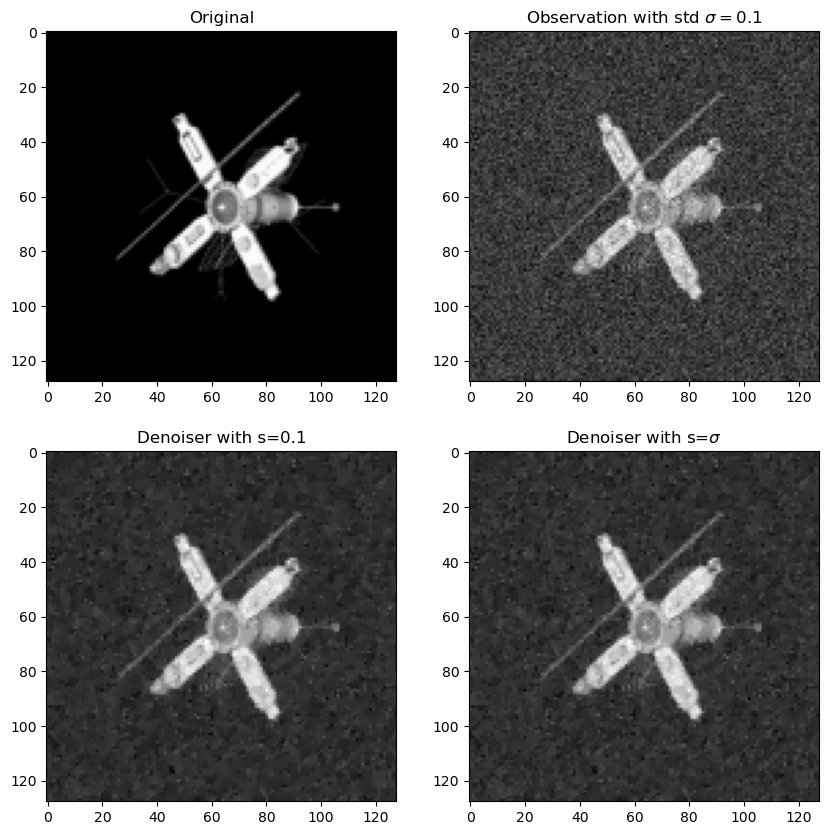

In [10]:
strength_reg = 50
restoration_strength = sigma2/10

N=int(np.sqrt(info.exactSolution.shape[0]))

from deepinv.models import TVDenoiser
device="cuda:0" if torch.cuda.is_available() else "cpu"
dinv_denoiser=TVDenoiser(n_it_max=25)
def denoiser(x, restoration_strength=None, strength_reg=None):
    xt=torch.tensor(np.reshape(x,(N,N)), device=device, dtype=torch.float32)
    xt=xt.unsqueeze(0).unsqueeze(0)
    weigth=restoration_strength*strength_reg
    xrt=dinv_denoiser(xt,weigth)
    xrt=torch.squeeze(xrt)
    xr=xrt.cpu().detach().numpy()
    return xr.flatten(), None

s=0.1
xt=torch.tensor(np.reshape(info.exactSolution, (N,N)), device=device, dtype=torch.float32)
xt=xt.unsqueeze(0).unsqueeze(0)
yt=xt+s*torch.randn(xt.shape, device=device)
xrt=dinv_denoiser(yt, s)
xr=torch.squeeze(xrt)
xr=xr.cpu().detach().numpy()

xr2t=dinv_denoiser(yt, sigma)
xr2=torch.squeeze(xr2t)
xr2=xr2.cpu().detach().numpy()
y=torch.squeeze(yt)
y=y.cpu().numpy()
fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(2,2,1)
ax1.imshow(np.reshape(info.exactSolution, (N, N)), cmap="gray")
ax1.set_title("Original")
ax2=fig.add_subplot(2,2,2)
ax2.imshow(y, cmap="gray")
ax2.set_title(r"Observation with std $\sigma={}$".format(s))
ax3=fig.add_subplot(2,2,3)
ax3.imshow(xr, cmap="gray")
ax3.set_title("Denoiser with s={}".format(s))
ax4=fig.add_subplot(2,2,4)
ax4.imshow(xr2, cmap="gray")
ax4.set_title(r"Denoiser with s=$\sigma$")

We save all the important variables into the variable
$\texttt{restorator}\_\texttt{kwargs}$.

In [11]:
restorator_kwargs = {}
restorator_kwargs["strength_reg"] = strength_reg

Now we can define our RestorationPrior.

In [12]:
restorator = RestorationPrior(
    denoiser,
    restoration_strength=restoration_strength,
    restorator_kwargs=restorator_kwargs,
    geometry=likelihood.model.domain_geometry
)

Illustration of the effect of the denoising restoration operator.
We first apply the restorate method of our restorator to $\mathbf{y}_{obs}$.
This operator should restore $\mathbf{y}_{obs}$ and generate a signal close
to $\mathbf{A}\mathbf{x}$.

In [13]:
res = restorator.restorate(y_obs)

In this cell, we show the effect of the restorator both from a visual
and quantitative point of view. We use the relative error and the mean-squared
error. The smaller are these quantities, the better it is.

(-0.5, 127.5, 127.5, -0.5)

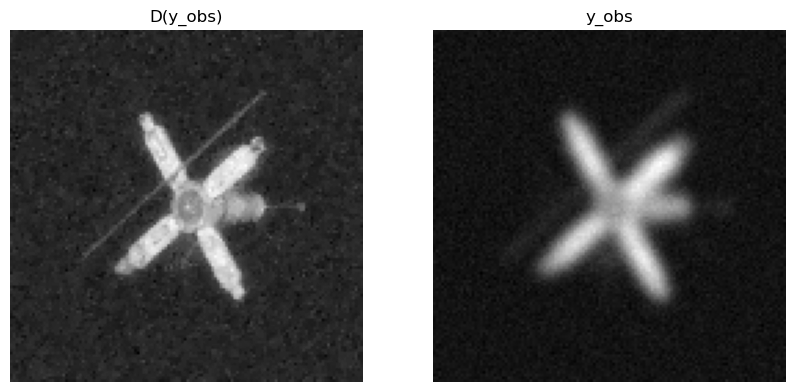

In [14]:
fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(1,2,1)
ax1.imshow(np.reshape(res, (N, N)), cmap="gray")
ax1.set_title("D(y_obs)")# MSE={}".format(mse(info.exactData, res)))
ax1.axis("off")
ax2=fig.add_subplot(1,2,2)
ax2.imshow(np.reshape(y_obs, (N, N)), cmap="gray")
ax2.set_title("y_obs")#MSE={}".format(mse(info.exactData,y_obs)))
ax2.axis("off")

#print("MSE(Ax, y_obs)/MSE(Ax, D(y_obs)) = ", mse(info.exactData,y_obs)/mse(info.exactData, res))

# Definition of the Moreau-Yoshida prior in CUQIPy

It is a smoothed version from the target prior. Its definition requires a prior
of type RestorationPrior and a scalar parameter $\texttt{smoothing}\_\texttt{strength}$
which controls the strength of the smoothing.

We must have
$\texttt{smoothing}\_\texttt{strength}=\texttt{restoration}\_\texttt{strength}$.

As suggested by Durmus et al. (https://arxiv.org/pdf/1612.07471), we set the
smoothing parameter $\texttt{smoothing}\_\texttt{strength} \approx \texttt{sigma2}$,
ie $\texttt{smoothing}\_\texttt{strength}= 0.1 \ \texttt{sigma2}$.

In [15]:
myprior = MoreauYoshidaPrior(prior=restorator, smoothing_strength=restoration_strength,
                            geometry=restorator.geometry)

# Implicitly defined posterior distribution with CUQIPy
We can now define the implicitly defined smoothed posterior distribution as
follows:

In [16]:
smoothed_posterior=Posterior(likelihood, myprior)

# Parameters of the MYULA sampler
We let run MYULA for $\texttt{Ns}=5000$
iterations. We discard the $\texttt{Nb}=1000$ first burn-in samples of
the Markov chain. Furthermore, as MCMC methods generate
correlated samples, we also perform a thinning: we only consider 1 samples
every $\texttt{Nt}=10$
samples to compute our quantities of interest.
$\texttt{scale}$ is set wrt the recommendation of Durmus et al.
(https://arxiv.org/pdf/1612.07471). It must be smaller than the inverse of the
Lipschitz constant of the gradient of the log-posterior density. In this setting,
The Lipschitz constant of the gradient of likelihood log-density is
$\|A^TA \|_2^2/\texttt{sigma2}$ and the one of the log-prior is
$1/\texttt{smoothing}\_\texttt{strength}$.

In [17]:
Ns=5000
Nb=1000
Nt=10

Step-size of MYULA

In [18]:
scale=0.9/(1/sigma2 + 1/restoration_strength)

In order to get reproducible results, we set the seed parameter to 0.

In [19]:
np.random.seed(0)

# ULA sampler
Definition of the ULA sampler which aims at sampling from the smoothed posterior.

In [20]:
ula_sampler=ULANew(target=smoothed_posterior, scale=scale)

Sampling with ULA from the smoothed target posterior.


In [21]:
ula_sampler.sample(Ns=Ns)

  0% (0 of 5000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (3 of 5000) |                       | Elapsed Time: 0:00:00 ETA:   0:03:40
  0% (6 of 5000) |                       | Elapsed Time: 0:00:00 ETA:   0:03:33
  0% (9 of 5000) |                       | Elapsed Time: 0:00:00 ETA:   0:03:29
  0% (12 of 5000) |                      | Elapsed Time: 0:00:00 ETA:   0:03:27
  0% (15 of 5000) |                      | Elapsed Time: 0:00:00 ETA:   0:03:32
  0% (18 of 5000) |                      | Elapsed Time: 0:00:00 ETA:   0:03:32
  0% (21 of 5000) |                      | Elapsed Time: 0:00:00 ETA:   0:03:30
  0% (24 of 5000) |                      | Elapsed Time: 0:00:01 ETA:   0:03:28
  0% (27 of 5000) |                      | Elapsed Time: 0:00:01 ETA:   0:03:28
  0% (30 of 5000) |                      | Elapsed Time: 0:00:01 ETA:   0:03:29
  0% (33 of 5000) |                      | Elapsed Time: 0:00:01 ETA:   0:03:32
  0% (36 of 5000) |                     

 Sampler: 
	 ULANew 
 Target: 
 	 Posterior(
    Equation:
	 p(myprior|y) ∝ L(myprior|y)p(myprior)
    Densities:
	y ~ CUQI Gaussian Likelihood function. Parameters ['x'].
 	myprior ~ CUQI MoreauYoshidaPrior.
 ) 
 Current state: 
	 current_point: [-0.0326392  -0.02276668  0.02655237 ...  0.01232238  0.02081434
  0.02001098] 
	 current_target_grad: [  57.95514243  222.3711313  -295.86404015 ...  115.42667455 -174.5295864
 -197.39297338] 
	 scale: 3.145643284051589e-05 

Retrieve the samples. We apply the burnin and perform thinning to the Markov
chain.

In [22]:
samples=ula_sampler.get_samples()
samples_warm=samples.burnthin(Nb=Nb, Nt=Nt)

Plot mean and standard deviation

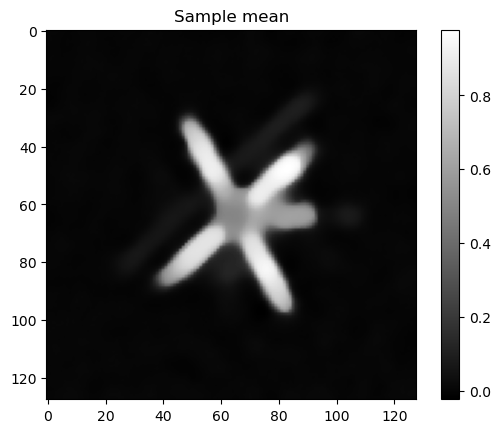

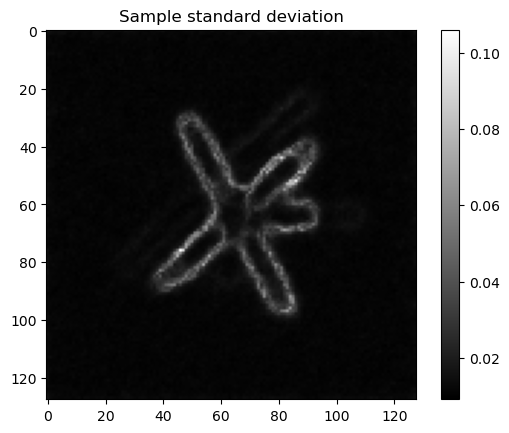

In [23]:
samples_warm.plot_mean()
plt.colorbar()

plt.figure()
samples_warm.plot_std()
plt.colorbar()

Samples autocorrelation plot.

Selecting 5 randomly chosen variables


array([[<Axes: title={'center': 'x2964'}>,
        <Axes: title={'center': 'x350'}>,
        <Axes: title={'center': 'x6624'}>],
       [<Axes: title={'center': 'x7159'}>,
        <Axes: title={'center': 'x7783'}>, <Axes: >]], dtype=object)

<Figure size 640x480 with 0 Axes>

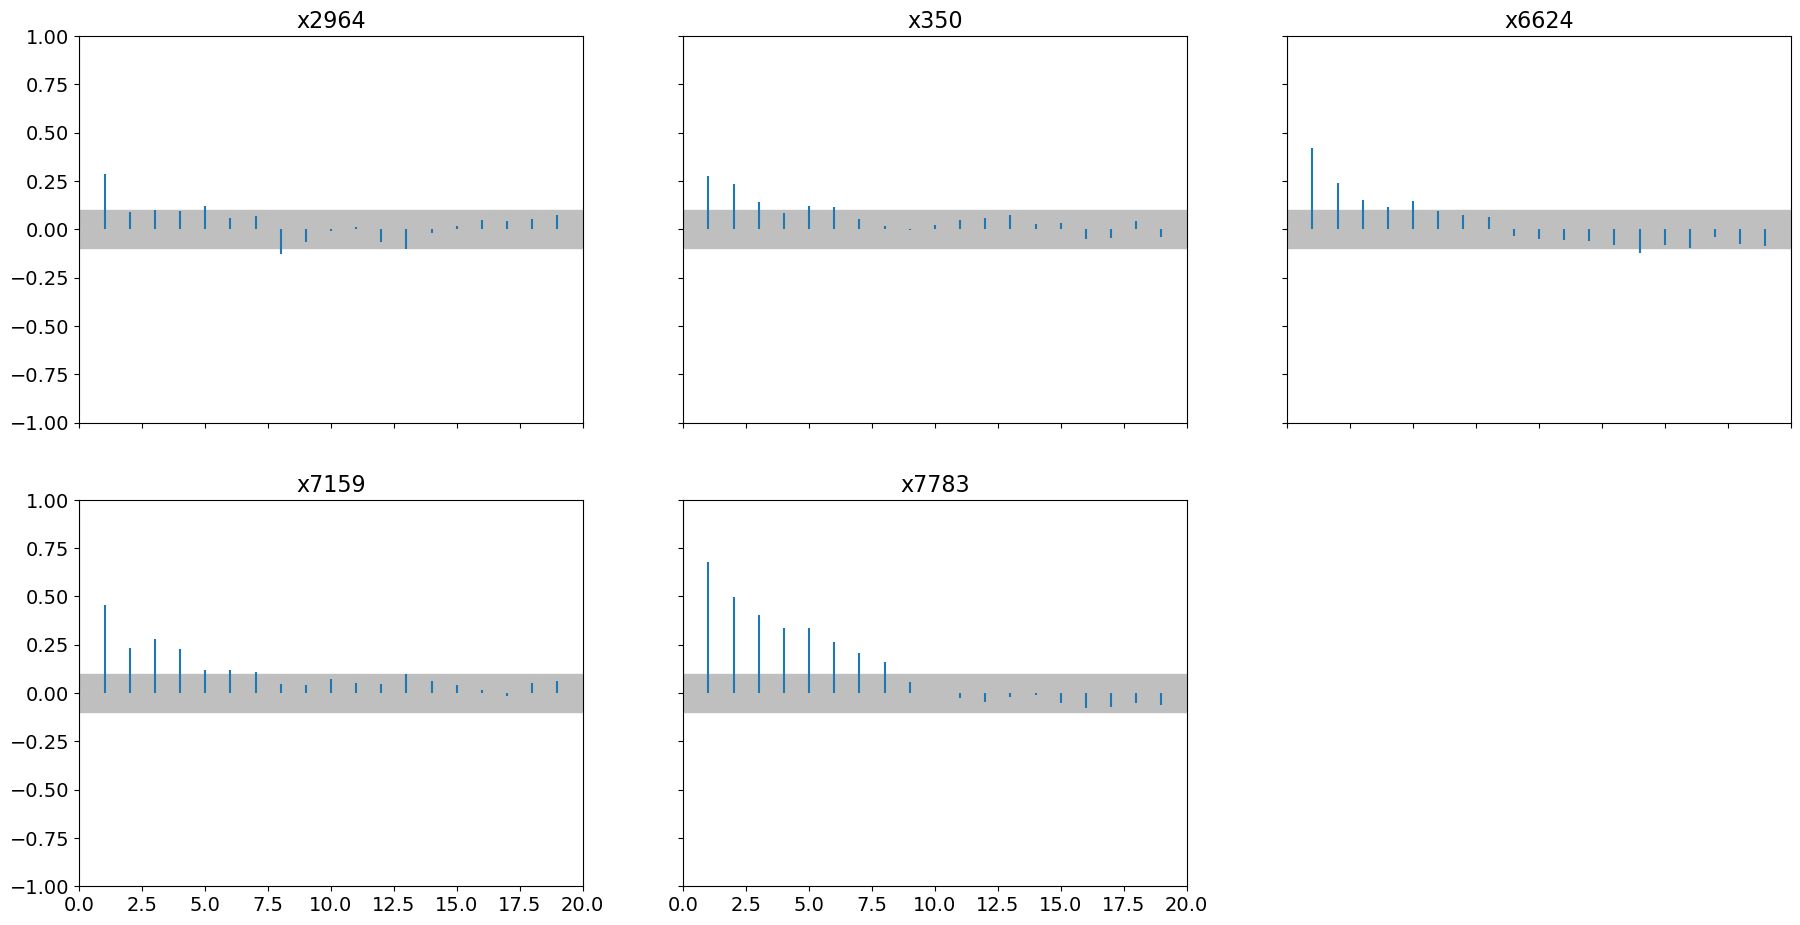

In [24]:
plt.figure()

samples_warm.plot_autocorrelation(max_lag=20)

# Other way to sample with MYULA in CUQIPy

To sample with MYULA, we can also define an implicit posterior with a
RestorationPrior object (instead of MoreauYoshidaPrior object) and then automatically
perform the Moreau-Yoshida smoothing when defining
the MYULA sampler.

In [25]:
posterior=Posterior(likelihood, restorator)

# Definition of the MYULA sampler
Again, we must have $\texttt{smoothing}\_\texttt{strength}=\texttt{restoration}\_\texttt{strength}$.

In [26]:
myula_sampler=MYULANew(target=posterior, scale=scale, smoothing_strength=restoration_strength)

We then sample using the MYULA sampler. It targets the same smoothed distribution
as the ULA sampler applied with the smoothed posterior distribution.

In [27]:
np.random.seed(0)
myula_sampler.sample(Ns=Ns)
samples_myula=myula_sampler.get_samples()
samples_myula_warm=samples_myula.burnthin(Nb=Nb, Nt=Nt)

  0% (0 of 5000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (2 of 5000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:44
  0% (4 of 5000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:40
  0% (6 of 5000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:34
  0% (8 of 5000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:33
  0% (10 of 5000) |                      | Elapsed Time: 0:00:00 ETA:   0:04:30
  0% (13 of 5000) |                      | Elapsed Time: 0:00:00 ETA:   0:04:23
  0% (16 of 5000) |                      | Elapsed Time: 0:00:00 ETA:   0:04:18
  0% (19 of 5000) |                      | Elapsed Time: 0:00:00 ETA:   0:04:14
  0% (22 of 5000) |                      | Elapsed Time: 0:00:01 ETA:   0:04:12
  0% (24 of 5000) |                      | Elapsed Time: 0:00:01 ETA:   0:04:12
  0% (27 of 5000) |                      | Elapsed Time: 0:00:01 ETA:   0:04:09
  0% (30 of 5000) |                     

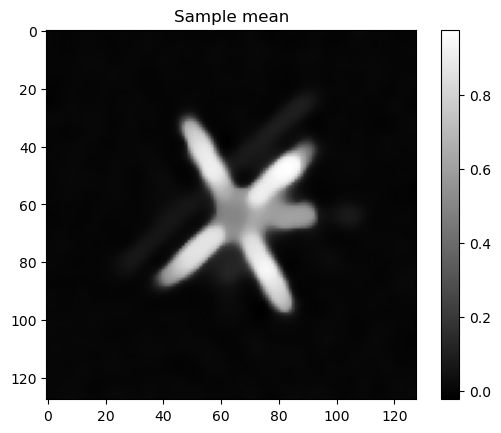

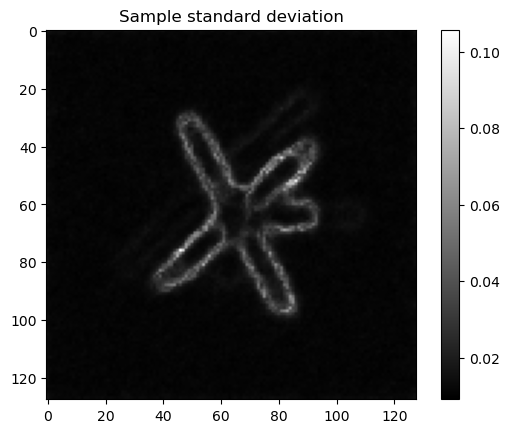

In [28]:
samples_myula_warm.plot_mean()
plt.colorbar()

plt.figure()
samples_myula_warm.plot_std()
plt.colorbar()